## Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import time
import math
import fractions
import os
import itertools
import re
from matplotlib import pyplot as plt

## Load dataset

In [157]:
csv_list = ['bank_accounts.csv','credit_cards.csv', 'devices.csv', 'orders.csv']
files = []
name_list = []

for i in csv_list:
    name = i[0:-4]
    globals()[name] = pd.read_csv(i, dtype = object)
    files.append(globals()[name])
    name_list.append(name)

In [158]:
for i in files:
    display(i.head())

,userid,bank_account
0,21829134,923302000003892
1,95910542,011002023212822
2,96941876,0189303223
3,23452396,2280003199803
4,12647942,032002028484803


,userid,credit_card
0,2579938,832299xxxxxx4902|02-2019
1,2154902,322429xxxxxx3848|05-2020
2,5578604,322429xxxxxx1293|11-2016
3,2051728,388329xxxxxx4303|09-2016
4,6216212,322421xxxxxx4238|05-2018


,userid,device
0,10499978,0Zu/mWZ4cFsvobYglgZEc5VSxwwajRwrm74pBuwnrTu=
1,54526742,zBMRKyz98iy5Z7sh+JIOdF612J1CB8ggvFBI6MP361q=
2,33152428,KXC0oY3MMrTG+bnlFFvBPXZC5PW8iw6kgWztENWdIJg=
3,55020986,anRXS7+zVgCGKz5C9X3dzewIhSdojGEi5TO07pb2y+K=
4,100471502,hbIARr+USwvjjzc8QUVtD5a/apR1DJX6P3fYvgDL4gW=


,orderid,buyer_userid,seller_userid
0,1953278092,47388162,20822974
1,1953295120,26855196,16416890
2,1953306402,121296714,28477978
3,1953314712,131221930,72837912
4,1953381964,183398314,28423332


## Join dataframes to order

In [65]:
# Create dictionaries for all user IDs
# dict_list = []

# for j, i in enumerate(files[0:-1]):
#     name = name_list[j] + '_dict'
#     globals()[name] = dict(zip(i.iloc[:,0], i.iloc[:,1]))
#     dict_list.append(globals()[name])

In [159]:
# Append type of connection
for val, i in enumerate(files[0:-1]):
    i.iloc[:,1] = i.iloc[:,1].apply(lambda x: '"' + name_list[val][0:-1] + ':' + str(x) + '"')
    
for i in files:
    display(i.head())

,userid,bank_account
0,21829134,"""bank_account:923302000003892"""
1,95910542,"""bank_account:011002023212822"""
2,96941876,"""bank_account:0189303223"""
3,23452396,"""bank_account:2280003199803"""
4,12647942,"""bank_account:032002028484803"""


,userid,credit_card
0,2579938,"""credit_card:832299xxxxxx4902|02-2019"""
1,2154902,"""credit_card:322429xxxxxx3848|05-2020"""
2,5578604,"""credit_card:322429xxxxxx1293|11-2016"""
3,2051728,"""credit_card:388329xxxxxx4303|09-2016"""
4,6216212,"""credit_card:322421xxxxxx4238|05-2018"""


,userid,device
0,10499978,"""device:0Zu/mWZ4cFsvobYglgZEc5VSxwwajRwrm74pBu..."
1,54526742,"""device:zBMRKyz98iy5Z7sh+JIOdF612J1CB8ggvFBI6M..."
2,33152428,"""device:KXC0oY3MMrTG+bnlFFvBPXZC5PW8iw6kgWztEN..."
3,55020986,"""device:anRXS7+zVgCGKz5C9X3dzewIhSdojGEi5TO07p..."
4,100471502,"""device:hbIARr+USwvjjzc8QUVtD5a/apR1DJX6P3fYvg..."


,orderid,buyer_userid,seller_userid
0,1953278092,47388162,20822974
1,1953295120,26855196,16416890
2,1953306402,121296714,28477978
3,1953314712,131221930,72837912
4,1953381964,183398314,28423332


In [160]:
# Appending field information per userid
cols = ['buyer', 'seller']

for i in cols:
    for val, j in enumerate(name_list[0:-1]):
        temp = files[val].groupby('userid').apply(lambda x: set(x.iloc[:,1]))
        orders.loc[:, i+'_'+j] = orders.loc[:, i+'_userid'].map(temp)

In [161]:
# Fillna with empty set
for i in orders.columns[3:]:
    orders.loc[orders[i].isna(), orders[i].name] = [set()]

## Direct Links

Check if ANY of the fields (bank account, credit card, or devices) for buyer and seller are the same in an order.


Order of priority: Credit Card > Bank Account > Device.

In [162]:
# Prepare df containing intersected sets
frauds = orders.iloc[:,0:3]

In [163]:
# Append intersections
for i in name_list[0:-1]:
    a = [cols for cols in orders.columns if cols.endswith(i)]
    frauds.loc[:,i] = orders.loc[:,a].apply(lambda x: x.iloc[0].intersection(x.iloc[1]), axis = 1)

In [164]:
# Direct links formatting
df_listed = pd.DataFrame(columns = ['orderid','buyer_userid','seller_userid','match'])

for i in ['credit_cards', 'bank_accounts','devices']:
    a = frauds[frauds.loc[:,i] != set()].loc[:,['orderid','buyer_userid','seller_userid',i]]
    a.rename(columns = {i: 'match'}, inplace = True)
    df_listed = pd.concat((df_listed, a), axis = 0, sort = False)
    
df_listed = df_listed.drop_duplicates(subset = 'orderid', keep = 'first')

In [166]:
# Final formatting
direct_csv = pd.DataFrame(columns = ['orderid','is_fraud'])
direct_csv.loc[:,'orderid'] = df_listed.orderid
direct_csv.loc[:,'is_fraud'] = df_listed.apply(lambda x:
                                str(x.buyer_userid) + '-' + str(list(x.match)[0]) + '->' + str(x.seller_userid), axis = 1)

# Append not fraudulent 
a = pd.DataFrame(orders.orderid[~orders.orderid.isin(df_listed.orderid.unique())])
a.loc[:,'is_fraud'] = 'not fraud'
direct_csv = pd.concat((direct_csv,a), axis = 0)
direct_csv.set_index('orderid', inplace = True)

#Display example
direct_csv.head()

,is_fraud
orderid,
1954198318,"221232712-""bank_account:8300298809""->66353306"
1955955178,"235599454-""bank_account:9120282009""->51098362"
1954692012,"104954088-""bank_account:229002004223803""->9323..."
1954398710,"210580366-""bank_account:1000023914228""->5349078"
1954169068,"235427122-""bank_account:029302092091803""->7441..."


## Network Analysis

In [11]:
import networkx as nx

In [197]:
# Create graph
G = nx.Graph()

# Create userids nodes
buyer_set = set(orders.buyer_userid)
sellers_only = set(orders.seller_userid) - buyer_set
user_ids = list(buyer_set) + list(sellers_only)

# for i in user_ids:
#     G.add_node(str(i))

# Create edges from dataframes
for val, i in enumerate(files[0:-1]):
    edges_list = list(zip(i.iloc[:,0].astype(str), i.iloc[:,1]))
    G.add_edges_from(edges_list)

In [198]:
# Get shortest path
buy_sell = list(zip(orders.buyer_userid.astype(str),orders.seller_userid.astype(str)))

# Create fraud dataframe
indirect_fraud = orders.iloc[:,0:3]
indirect_fraud.loc[:,'is_fraud'] = None

# Store all the buyer-seller combinations for fraud
fraud_combos = []
order_list = []

# append to fraud dataframe those with only one shortest path
for val, i in enumerate(buy_sell):
    try:
        if nx.has_path(G, i[0], i[1]):
            fraud_combos.append((i[0], i[1]))
            order_list.append(orders.loc[val, 'orderid'])
            if len([p for p in nx.all_shortest_paths(G,i[0],i[1])]) == 1:
                indirect_fraud.at[val,'is_fraud'] = list(nx.shortest_path(G, i[0], i[1]))
    except:
        pass

In [199]:
# Remove those with only one shortest path
one_path = list(zip(indirect_fraud[indirect_fraud.is_fraud.notna()].buyer_userid, indirect_fraud[indirect_fraud.is_fraud.notna()].seller_userid))
fraud_combos = [i for i in fraud_combos if i not in one_path]

# Keep orderids corresponding to remaining fraud combos
order_list = [i for i in order_list if i not in indirect_fraud[indirect_fraud.is_fraud.notna()].orderid.unique()]

In [226]:
# Initalize list to keep all paths
final_paths = []

for i in fraud_combos:
    path_weight = []
    path_order = []
    short_path_list = [p for p in nx.all_shortest_paths(G, i[0], i[1])]
    for val in short_path_list:
        sample_num = [i[1] for i in val[1::2]]
        weight = int(str(sum([i == 'c' for i in sample_num])) + str(sum([i == 'b' for i in sample_num])) + str(sum([i == 'd' for i in sample_num])))
        path_weight.append(weight)
        path_order.append(sample_num)
    finalist = [i for i,val in zip(short_path_list, [i == max(path_weight) for i in path_weight]) if val]
    finalpath = [i for i,val in zip(path_order, [i == max(path_weight) for i in path_weight]) if val]
    finalpath = dict(Counter([tuple(elem) for elem in finalpath]))
    if len(finalpath) > 1:
        print(finalpath)
    final = sorted(finalist)[0]
    final_paths.append(final)

{('b', 'd', 'b', 'd', 'd', 'b', 'd', 'd'): 6, ('b', 'd', 'd', 'b', 'd', 'b', 'd', 'd'): 24}


In [220]:
from collections import Counter
a = [['d', 'd'], ['d', 'd']]
dict(Counter([tuple(elem) for elem in a]))

{('d', 'd'): 2}

In [201]:
# Map using dictionary on orderid
indirect_fraud.loc[indirect_fraud.orderid.isin(order_list), 'is_fraud'] = indirect_fraud.loc[indirect_fraud.orderid.isin(order_list)].orderid.map(dict(zip(order_list, final_paths)))

# Fill in not fraud
indirect_fraud.loc[indirect_fraud.is_fraud.isna(), 'is_fraud'] = 'not fraud'

# Fix format of pathway
indirect_fraud.loc[indirect_fraud.is_fraud != 'not fraud', 'is_fraud'] = indirect_fraud[indirect_fraud.is_fraud != 'not fraud'].is_fraud.apply(lambda x: ('"->').join(('-').join(x).split('"-')))

# Keep two columns
indirect_csv = pd.DataFrame(indirect_fraud.set_index('orderid').loc[:,'is_fraud'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [206]:
finalist

[['111271962', '"bank_account:0323129990"', '66519400'],
 ['111271962', '"bank_account:2099092333"', '66519400']]

In [195]:
direct_csv

,is_fraud
orderid,
1954198318,"221232712-""bank_account:8300298809""->66353306"
1955955178,"235599454-""bank_account:9120282009""->51098362"
1954692012,"104954088-""bank_account:229002004223803""->9323..."
1954398710,"210580366-""bank_account:1000023914228""->5349078"
1954169068,"235427122-""bank_account:029302092091803""->7441..."
1955252130,"100918044-""bank_account:0390313892""->68742042"
1953890506,"4748430-""bank_account:2212934039""->21964656"
1954307678,"162360172-""bank_account:2020292031""->64897430"
1956337482,"174397422-""bank_account:9828092929""->172696026"


In [205]:
# export as csv
indirect_csv.to_csv('pat_test.csv')

In [632]:
# Order of number is CBD
path_weight = []

for val in [p for p in nx.all_shortest_paths(G, '16885892', '10797932')]:
    sample_num = [i[0] for i in val[1::2]]
    weight = int(str(sum([i == 'c' for i in sample_num])) + str(sum([i == 'b' for i in sample_num])) + str(sum([i == 'd' for i in sample_num])))
    path_weight.append(weight)

In [638]:
sum([i == 85 for i in path_weight])

484

In [635]:
len(path_weight)

2548

In [601]:
indirect_fraud

,orderid,buyer_userid,seller_userid,isfraud
0,1953278092,47388162,20822974,None
1,1953295120,26855196,16416890,None
2,1953306402,121296714,28477978,None
3,1953314712,131221930,72837912,None
4,1953381964,183398314,28423332,None
5,1953383372,69247284,62795594,None
6,1953451192,89510674,18186196,None
7,1953453596,198638326,7314602,None
8,1953479046,202508756,1988634,None
9,1953480060,130236220,77145726,None


In [565]:
nx.shortest_path(G, i[0], i[1])

['221232712', 'bank_account:8300298809', '66353306']

In [553]:
G.has_node(n='76558244')

False

In [536]:
orders[orders.buyer_userid == 141797242]

,orderid,buyer_userid,seller_userid,buyer_bank_accounts,buyer_credit_cards,buyer_devices,seller_bank_accounts,seller_credit_cards,seller_devices
103,1954478166,141797242,76558244,{},{},{device:wtThlfX2wvU/1rH8Iqa0k30GZmQB76qulyjbFv...,{},{},{}
323671,1954454084,141797242,76558244,{},{},{device:wtThlfX2wvU/1rH8Iqa0k30GZmQB76qulyjbFv...,{},{},{}


In [562]:
76558244 in user_ids

False

'47388162'

----------------------

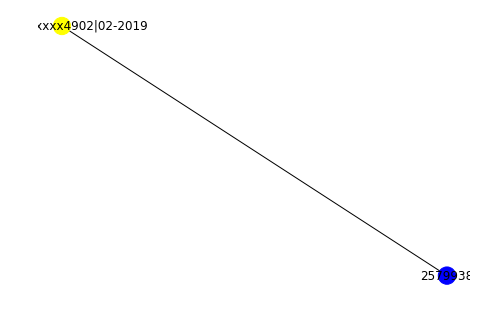

In [402]:
# Create graph
G = nx.Graph()

# Create credit card nodes
G.add_node('2579938', type = 'user')
G.add_node('832299xxxxxx4902|02-2019',type = 'cc')

# Draw network
G.add_edges_from([('2579938','832299xxxxxx4902|02-2019')])

# Set different colors
color_map = nx.get_node_attributes(G, "type")

for key in color_map:
    if color_map[key] == 'cc':
        color_map[key] = 'yellow'
    if color_map[key] == 'user':
        color_map[key] = 'blue'

type_colors = [color_map.get(node) for node in G.nodes()]

# Draw network
nx.draw(G, with_labels = True, node_color = type_colors)
plt.show()